In [47]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import norm
import fitsio

import time

import pickle
import dask
pd.options.mode.chained_assignment = None

## Creating Conda Environment:


```bash
    module load python
    conda create -c conda-forge -n nersc_clusters \
        python=3 dask distributed ipykernel numpy jupyter-server-proxy bokeh=2.0 scikit-learn pandas scipy astropy matplotlib fitsio
    source desi_clusters
```

```bash
    wget https://bitbucket.org/mpi4py/mpi4py/downloads/mpi4py-3.0.0.tar.gz
    tar zxvf mpi4py-3.0.0.tar.gz
    cd mpi4py-3.0.0
    module swap PrgEnv-intel PrgEnv-gnu
    module unload craype-hugepages2M
    python setup.py build --mpicc="$(which cc) -shared"
    python setup.py install
```

The final step installs `dask-mpi` itself.
```bash
    conda install -c conda-forge --no-deps dask-mpi
```


```bash
export OMP_NUM_THREADS=16
module load python
source activate nersc_clusters
cd $SCRATCH
rm -rf scheduler.json
salloc \
        -N 1 \
        -n 17 \
        -c 16 \
        -t 30 \
        -C knl \
        -q interactive \
        srun -u python -u \
            $(which dask-mpi) \
                --scheduler-file=scheduler.json \
                --dashboard-address=0 \
                --memory-limit='auto' \
                --no-nanny \
                --local-directory=/tmp
```

```bash
export OMP_NUM_THREADS=4
module load python
source activate nersc_clusters
cd $SCRATCH
rm -rf scheduler.json
salloc \
        -N 1 \
        -n 16 \
        -c 4 \
        -t 230 \
        -C haswell \
        -q interactive \
        srun -u python -u \
            $(which dask-mpi) \
                --scheduler-file=scheduler.json \
                --dashboard-address=0 \
                --memory-limit='auto' \
                --no-nanny \
                --local-directory=/tmp
```

In [48]:
import dask
from dask.distributed import Client
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 503.05 GiB


In [49]:
import os

scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
client = Client(scheduler_file=scheduler_file)

In [50]:
client

Client Scheduler: tcp://10.128.0.178:39159 Dashboard: /user/mjyb16/cori-shared-node-cpu/proxy/10.128.0.178:46645/status,Cluster Workers: 15 Cores: 60 Memory: 1.73 TiB


In [51]:
#client.close()

In [52]:
# load table of centers
table_of_centers = pd.read_csv("/global/cscratch1/sd/mjyb16/table_of_centers_dr9_best.csv")
table_of_centers_south = table_of_centers[0:455].copy()
table_of_centers_north = table_of_centers[455:].copy()
table_of_centers_south = table_of_centers_south[200:].copy()
table_of_centers_south.reset_index(inplace = True, drop = True)
clusters = []
#testing_centers = pd.read_csv("testing_sweeps_dr9.csv")
#testing_centers = table_of_centers_south[50:72]
#testing_centers = testing_centers[1:]

In [53]:
np.seterr(divide = 'ignore', invalid = "ignore") 
#np.seterr(divide = 'warn', invalid = 'warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [54]:
#Finding neighboring sweeps
nbrs = NearestNeighbors(n_neighbors=9, algorithm='ball_tree').fit(table_of_centers_south[["mean_RA", "mean_DEC"]].values.astype(float))

In [55]:
@dask.delayed
def data_import(maxx, maxy, minx, miny, row2):
    buffer = 0.285
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

In [56]:
@dask.delayed
def cluster_finder(massive_sample_original, iterrator, indexable, gauss_array, maxRA, maxDEC, minRA, minDEC, oversample, radius = 1, small_radius = 0.5, mini_radius = 0.1):
    #Mass fitting parameters and equations
    a = 1.3620186928378857  
    b = 9.968545069745126
    j= 1.04935943 
    k = 0.39573094 
    l = 0.28347756
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)

    def mass_coefficient(z):
        return np.exp(j*z**2 + k*z + l)
    
    #Radii
    radius = 1
    small_radius = 0.5
    mini_radius = 0.1
    #Cosmological Parameters: radius and cylinder length
    #Setting cylinder size
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, 2, 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    z_source = Table.read("threshold_training_south.fits", format = "fits")
    #z_source = Table.read("threshold_training_south.fits", format = "fits")
    z_data_array = z_source.to_pandas()
    z_threshold = interp1d(z_data_array.z, z_data_array.sigma_z_threshold, kind = "linear", fill_value = "extrapolate")

    #Setting neighbor thresholds
    t_source = Table.read("neighbor_training_south.fits", format = "fits")
    #t_source = Table.read("neighbor_training_south.fits", format = "fits")
    t_data_array = t_source.to_pandas()
    thresh1 = interp1d(t_data_array.z, t_data_array.neighbor_threshold1, kind = "linear", fill_value = "extrapolate")
    thresh2 = interp1d(t_data_array.z, t_data_array.neighbor_threshold2, kind = "linear", fill_value = "extrapolate")
    
    #Mass fitting parameters and equations
    a = 1.3620186928378857  
    b = 9.968545069745126
    j= 1.04935943 
    k = 0.39573094 
    l = 0.28347756
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)

    def mass_coefficient(z):
        return np.exp(j*z**2 + k*z + l)
    
    #Tree Algorithm
    massive_sample = massive_sample_original.copy()
    tree = spatial.cKDTree(indexable[:, 1:3].astype(float), copy_data = True)
    for i, row in iterrator.iterrows():
        neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.Z_PHOT_MEDIAN))
        if len(neighbors) > 0:
            local_data = indexable[neighbors]
            gauss = gauss_array[neighbors]
            
            z_c = z_threshold(row.Z_PHOT_MEDIAN)
            #cylinder = np.abs(np.vstack(gauss) - row.Z_PHOT_MEDIAN) #try reshape, try ravel, try flatten to make it 1-D. Try adding interp1D
            cylinder = np.abs(np.reshape(np.concatenate(gauss.flatten()), (len(gauss), oversample)) - row.Z_PHOT_MEDIAN)
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample
            
            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]
            if len(cluster)>0:
                r_smaller = radius_threshold(row.Z_PHOT_MEDIAN)
                small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2, dtype = float)) < 0.5*r_smaller]
                mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2, dtype = float)) < 0.1*r_smaller]

                massive_sample.at[i, "z_average_no_wt"] = np.mean(cluster[:, 0], dtype=np.float64)
                massive_sample.at[i, "z_average_prob"] = np.average(cluster[:, 0], weights = cluster[:, -1])
                massive_sample.at[i, "z_average_mass_prob"] = np.average(cluster[:, 0], weights = cluster[:, -1]*cluster[:, 3])

                massive_sample.at[i, "z_std_no_wt"] = np.std(cluster[:, 0], dtype=np.float64)
                massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
                massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))

                massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
                massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
                massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])

                mass_co = mass_coefficient(row.Z_PHOT_MEDIAN)
                massive_sample.at[i, "correction_factor"] = mass_co
                c_mask = cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
                cluster_limited = cluster[c_mask.astype("bool"), :]
                massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_co)
                massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
                massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))
                massive_sample.at[i, "corr_local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass]))*mass_co)
                massive_sample.at[i, "corr_ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass]))*mass_co)

                clusterid = np.ones((1, len(local_data)))*row.gid
                clusterz = np.ones((1, len(local_data)))*row.Z_PHOT_MEDIAN
                membership = np.concatenate((local_data[:, 4].reshape((1, len(local_data))), clusterid, local_data[:, 0].reshape((1, len(local_data))), clusterz, local_data[:, 5].reshape((1, len(local_data)))), axis = 0).T
                massive_sample.at[i, "neighbor_gids"] = membership
            else:
                clusterid = np.ones((1, len(local_data)))*row.gid
                clusterz = np.ones((1, len(local_data)))*row.Z_PHOT_MEDIAN
                membership = np.concatenate((local_data[:, 4].reshape((1, len(local_data))), clusterid, local_data[:, 0].reshape((1, len(local_data))), clusterz, local_data[:, 5].reshape((1, len(local_data)))), axis = 0).T
                massive_sample.at[i, "neighbor_gids"] = membership
            
            
    #Thresholding
    clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.Z_PHOT_MEDIAN), massive_sample.local_neighbors >= thresh2(massive_sample.Z_PHOT_MEDIAN))].copy()
    clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
    clusters.reset_index(inplace= True, drop = True)
    
    #Aggregation
    tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)
    clusters["ncluster"] = np.zeros(len(clusters))
    clusternum = 1
    iterrator2 = clusters.copy()
    for i, row in iterrator2.iterrows():
        if clusters.iloc[i].ncluster == 0:
            clusters.at[i, "ncluster"] = clusternum
            neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.Z_PHOT_MEDIAN))
            for index in neighbors:
                if np.logical_and(clusters.at[index, "ncluster"] == 0, np.abs(clusters.at[index, "Z_PHOT_MEDIAN"] - row.Z_PHOT_MEDIAN) < 2*z_threshold(row.Z_PHOT_MEDIAN)):
                    clusters.at[index, "ncluster"] = clusternum
                    clusters.at[i, "neighbor_gids"] = np.concatenate((clusters.at[i, "neighbor_gids"], clusters.at[index, "neighbor_gids"]), axis = 0) 
            clusternum += 1
    
    #Results
    cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
    cluster_center_selected = cluster_center[np.logical_and.reduce((cluster_center.RA < maxRA, cluster_center.RA > minRA, cluster_center.DEC < maxDEC, cluster_center.DEC > minDEC))].copy()
    
    #Membership
    membership = pd.DataFrame(cluster_center_selected.neighbor_gids.values)
    membership_data = np.zeros((1, 5))
    for i in range(0, len(membership)):
        temp = np.stack(membership.values[i])[0]
        membership_data = np.concatenate([membership_data, temp], axis = 0)
    membershippd = pd.DataFrame(membership_data[1:], columns = ["galaxy", "cluster", "galaxy_z", "cluster_z", "galaxy_z_std"], dtype = float)
    membershippd["z_dist"] = np.abs(membershippd.galaxy_z - membershippd.cluster_z)
    membershippd.sort_values("z_dist", ascending = True, inplace = True)
    membershippd.drop_duplicates(subset = "galaxy", inplace = True)
    membershippd.reset_index(inplace = True, drop = True)
    
    membershippd["prob"] = 2*(1-norm.cdf(x = np.abs(membershippd.galaxy_z-membershippd.cluster_z), loc = 0, scale = membershippd.galaxy_z_std))
    memberspd = membershippd[membershippd.prob > 0.0027].astype({"galaxy": "int64", "cluster": "int64"}).drop(columns = {"z_dist"})
    
    #Cleaning things up
    cluster_center_selected["BRICKNAME"] = cluster_center_selected["BRICKNAME"].astype('|S80')
    clusters_final = cluster_center_selected[["RA", "DEC", "Z_PHOT_MEDIAN", "z_average_no_wt", "z_average_prob", "z_average_mass_prob", "Z_PHOT_STD", "z_std_no_wt", "z_std_prob", "z_std_mass_prob", "RELEASE", "BRICKID", "OBJID", "MASKBITS", "gid", "mass", "neighbor_mass", "corr_local_neighbor_mass", "corr_ultra_local_neighbor_mass", "correction_factor", "neighbors", "local_neighbors", "ultra_local_neighbors"]].copy()
    clusters_final.columns = ["RA_central", "DEC_central", "z_median_central", "z_average_no_wt", "z_average_prob", "z_average_mass_prob", "z_std_central", "z_std_no_wt", "z_std_prob", "z_std_mass_prob", "RELEASE", "BRICKID", "OBJID", "MASKBITS", "gid", "mass_central", "neighbor_mass", "local_neighbor_mass", "ultra_local_neighbor_mass", "correction_factor", "neighbors", "local_neighbors", "ultra_local_neighbors"]
    
    return clusters_final, memberspd
    #return ["test"], ["test"]

In [57]:
delayed_results = []
pbar = display.ProgressBar(len(table_of_centers_south))
pbar.display()

#Remember to change testing_centers to table_of_centers
for index, row in table_of_centers_south.iterrows():
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    print(len(sweep))
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])
    
    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])
    
    list_of_imports = []
    #Neighbors:
    distances, indices = nbrs.kneighbors([row[["mean_RA", "mean_DEC"]].values.astype(float)])
    
    patches = table_of_centers_south.iloc[indices[0]]
    #patches = table_of_centers_south.iloc[indices[0]]
    for index2, row2 in patches.iterrows():
        delayed_import = data_import(maxx, maxy, minx, miny, row2)
        list_of_imports.append(delayed_import)
    
    imports = dask.compute(*list_of_imports)
    print("done import")
    ra_dec = pd.concat(imports)
    #ra_dec = pd.concat(list_of_imports)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]
    
    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
    
    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6
    
    #Oversampling
    ra_dec.reset_index(inplace = True, drop = True)
    oversample = 30
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss), dtype = "object")
    
    #Coordinate transform to prevent zeros
    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    #ra_dec = ra_dec[ra_dec.Z_PHOT_MEDIAN < 1.5].copy()
    #Creating array for indexing
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gid", "Z_PHOT_STD"]].values.astype(float)
    gauss = ra_dec[["gauss_z"]].values
    
    #Creating massive sample
    massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
    massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corr_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corr_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["neighbors"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_gids"] = np.empty((len(massive_sample)), dtype = "object")
    massive_sample["z_average_no_wt"] = np.zeros(len(massive_sample))
    massive_sample["z_average_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_average_mass_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_std_no_wt"] = np.zeros(len(massive_sample))
    massive_sample["z_std_prob"] = np.zeros(len(massive_sample))
    massive_sample["z_std_mass_prob"] = np.zeros(len(massive_sample))
    massive_sample["correction_factor"] = np.zeros(len(massive_sample))
    massive_sample.reset_index(inplace=True, drop = True)
    
    iterrator = massive_sample.copy()
    massive_sample = dask.delayed(massive_sample)
    indexable = dask.delayed(indexable)
    iterrator = dask.delayed(iterrator)
    gauss = dask.delayed(gauss)
    delayed_result = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)
    delayed_results.append(delayed_result)
    
    if (index)%15 == 0:
        t0 = time.time()
        results = dask.compute(*delayed_results)
        #timed_result = cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)
        #%prun cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)
        t1 = time.time()
        print(t1-t0)
        if len(results)>1:
            cluster_centrals = pd.concat([select[0] for select in results])
            cluster_members = pd.concat([select[1] for select in results])
        else:
            cluster_centrals = results[0][0]
            cluster_members = results[0][1]
        cc = Table.from_pandas(cluster_centrals)
        cm = Table.from_pandas(cluster_members)
        cc.write(f'DR9/results_south/c{200+index}.fits', format = 'fits')
        cm.write(f'DR9/results_south_neighbors/m{200+index}.fits', format = 'fits')
        del delayed_result, delayed_results, cluster_centrals, cluster_members
        delayed_results = []
    
    if index+1 == len(table_of_centers_south):
        
        results = dask.compute(*delayed_results)
        if len(results)>1:
            cluster_centrals = pd.concat([select[0] for select in results])
            cluster_members = pd.concat([select[1] for select in results])
        else:
            cluster_centrals = results[0][0]
            cluster_members = results[0][1]
        cc = Table.from_pandas(cluster_centrals)
        cm = Table.from_pandas(cluster_members)
        cc.write(f'DR9/results_south/c{200+index}.fits', format = 'fits')
        cm.write(f'DR9/results_south_neighbors/m{200+index}.fits', format = 'fits')
    
    
    pbar.progress = index

[=========================================================== ] 254/255

3649740
done import
91.41768407821655
5293148
done import
1508254
done import
5204061
done import
4527728
done import
3528458
done import
4293722
done import
3368743
done import
4356355
done import
4091466
done import
3380796
done import
4351020
done import
3982712
done import
2693119
done import
2461660
done import
4829938
done import
246.35270190238953
4800560
done import
3326787
done import
1291
done import
4201272
done import
4
done import
5571002
done import
3741576
done import
4471575
done import
3967891
done import
247320
done import
474426
done import
713186
done import
2651107
done import
2477125
done import
5165152
done import
181.79366207122803
1673887
done import
3470113
done import
4415899
done import
2861655
done import
20566
done import
4836495
done import
4026038
done import
149552
done import
3895941
done import
4098184
done import
3205005
done import
6312539
done import
4003426
done import
5827879
done import
802590
done import
209.20486116409302
1303220
done import
6

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [17]:
cluster_centrals.sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "neighbor_mass"]].tail(50)

,RA_central,DEC_central,neighbor_mass
491,286.019892,73.364152,12.497225
2141,212.886428,40.125878,12.496074
1120,178.084494,57.131546,12.494772
1730,170.648421,57.448672,12.491976
2685,247.293827,46.701134,12.489516
439,282.099665,70.329643,12.488798
3193,218.205446,42.340400,12.487801
559,288.213921,70.116405,12.487230
1380,175.743171,57.571378,12.484692
2468,245.274662,45.699642,12.478794


In [97]:
%prun cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

[=========================================================== ] 39301/39302

<ipython-input-81-0f09792fd9c4>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-81-0f09792fd9c4>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         143815294 function calls (142203536 primitive calls) in 828.563 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   196520  173.069    0.001  173.069    0.001 socket.py:438(send)
2668023/1449632   68.418    0.000  196.284    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   346334   64.464    0.000   64.464    0.000 {method 'acquire' of '_thread.lock' objects}
        1   58.673   58.673  827.912  827.912 <ipython-input-81-0f09792fd9c4>:2(cluster_finder)
1943383/1943351   36.405    0.000   36.405    0.000 {built-in method numpy.array}
   560371   26.406    0.000   26.406    0.000 {method 'astype' of 'numpy.ndarray' objects}
   128021   25.563    0.000   25.563    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
  1100525   18.481    0.000   18.482    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   128021   17.546    0.000   68.060    0.001 interpolate.py:601(_call_linear)
 

In [103]:
%prun timed_result_2 = cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-101-e00ae800bae0>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-101-e00ae800bae0>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         83990715 function calls (82625298 primitive calls) in 367.668 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2657851/1439460   59.992    0.000  144.503    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   46.095   46.095  367.132  367.132 <ipython-input-101-e00ae800bae0>:2(cluster_finder)
   125020   19.533    0.000   55.698    0.000 interpolate.py:601(_call_linear)
1927004/1926972   18.790    0.000   18.790    0.000 {built-in method numpy.array}
   557370   17.629    0.000   17.629    0.000 {method 'astype' of 'numpy.ndarray' objects}
    40443   17.519    0.000   18.550    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   125020   16.038    0.000   16.038    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
  1100525   15.591    0.000   15.591    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   633977    7.554    0.000   28.069    0.

In [107]:
%prun timed_result_3 = cluster_finder(massive_sample, iterrator, indexable, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-106-1f239cd54f66>:59: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1].astype(float)))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-106-1f239cd54f66>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0].astype(float), aweights = cluster[:, -1]*cluster[:, 3].astype(float)))


         130717189 function calls (128641906 primitive calls) in 729.988 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4  165.743   41.436  165.757   41.439 {method 'factorize' of 'pandas._libs.hashtable.Float64HashTable' objects}
3774590/2150207   86.843    0.000  222.814    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   76.088   76.088  729.554  729.554 <ipython-input-106-1f239cd54f66>:2(cluster_finder)
2739066/2739028   30.822    0.000   30.823    0.000 {built-in method numpy.array}
   125020   27.908    0.000   27.908    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
   557379   22.484    0.000   22.484    0.000 {method 'astype' of 'numpy.ndarray' objects}
  1201789   18.467    0.000   18.467    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   125020   17.824    0.000   66.942    0.001 interpolate.py:601(_call_linear)
    40443   16.834    0.000   18.022 

In [157]:
%prun timed_result_4 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-153-f42c0e082c5e>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-153-f42c0e082c5e>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         83741191 function calls (82374835 primitive calls) in 166.251 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2660733/1441324   27.524    0.000   63.237    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   22.312   22.312  166.195  166.195 <ipython-input-153-f42c0e082c5e>:2(cluster_finder)
  1100535    8.487    0.000    8.487    0.000 {method 'reduce' of 'numpy.ufunc' objects}
1928801/1928766    5.636    0.000    5.636    0.000 {built-in method numpy.array}
   124968    5.171    0.000   14.025    0.000 interpolate.py:601(_call_linear)
   633951    4.849    0.000   17.850    0.000 indexing.py:2105(__setitem__)
    78604    4.597    0.000   18.402    0.000 function_base.py:2275(cov)
    40435    3.566    0.000    4.104    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   633951    3.197    0.000   10.156    0.000 frame.py:3251(_set_value)
   157208

In [160]:
%prun timed_result_5 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-158-9c2d3cf51fbe>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-158-9c2d3cf51fbe>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         130274876 function calls (128201965 primitive calls) in 226.215 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3770920/2147808   29.948    0.000   76.858    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   25.108   25.108  226.072  226.072 <ipython-input-158-9c2d3cf51fbe>:2(cluster_finder)
  1201473    9.386    0.000    9.386    0.000 {method 'reduce' of 'numpy.ufunc' objects}
2736248/2736210    7.067    0.000    7.068    0.000 {built-in method numpy.array}
   100924    6.195    0.000   28.326    0.000 _distn_infrastructure.py:1892(cdf)
   734875    5.793    0.000   21.053    0.000 indexing.py:2105(__setitem__)
   124968    5.318    0.000   14.283    0.000 interpolate.py:601(_call_linear)
    78604    4.621    0.000   18.536    0.000 function_base.py:2275(cov)
 11766657    3.976    0.000    5.217    0.000 {built-in method builtins.isinstance}
   302772    3.805    0.000    

In [162]:
%prun timed_result_6 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample)

<ipython-input-161-ab44d70f40b1>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-161-ab44d70f40b1>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         83749796 function calls (82383334 primitive calls) in 170.603 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
2660767/1441347   28.904    0.000   65.313    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   22.740   22.740  170.552  170.552 <ipython-input-161-ab44d70f40b1>:2(cluster_finder)
  1100550    8.636    0.000    8.637    0.000 {method 'reduce' of 'numpy.ufunc' objects}
1928870/1928828    5.842    0.000    5.843    0.000 {built-in method numpy.array}
   124968    5.292    0.000   14.521    0.000 interpolate.py:601(_call_linear)
   633951    4.942    0.000   18.134    0.000 indexing.py:2105(__setitem__)
    78604    4.605    0.000   18.799    0.000 function_base.py:2275(cov)
    40435    3.675    0.000    4.214    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   633951    3.201    0.000   10.289    0.000 frame.py:3251(_set_value)
   157208

In [171]:
%prun timed_result_7 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample) #South

<ipython-input-167-d2ca49cc88d9>:60: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-167-d2ca49cc88d9>:61: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         119786121 function calls (118026948 primitive calls) in 260.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3403934/1931453   64.404    0.000  109.906    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1   30.995   30.995  259.820  259.820 <ipython-input-167-d2ca49cc88d9>:2(cluster_finder)
  1326734   10.363    0.000   10.363    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   209598    8.677    0.000   24.350    0.000 interpolate.py:601(_call_linear)
2607612/2607570    7.493    0.000    7.494    0.000 {built-in method numpy.array}
   786019    6.050    0.000   22.135    0.000 indexing.py:2105(__setitem__)
    94760    5.342    0.000   22.109    0.000 function_base.py:2275(cov)
    51341    4.833    0.000    5.518    0.000 {method 'query_ball_point' of 'scipy.spatial.ckdtree.cKDTree' objects}
   209598    4.068    0.000    4.068    0.000 {method 'searchsorted' of 'numpy.

In [64]:
%prun timed_result_8 = cluster_finder(massive_sample, iterrator, indexable, gauss, maxRA, maxDEC, minRA, minDEC, oversample) #North

<ipython-input-60-1764dc8b64c8>:76: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]))
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/global/homes/m/mjyb16/.conda/envs/nersc_clusters/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-60-1764dc8b64c8>:77: RuntimeWarning: Degrees of freedom <= 0 for slice
  massive_sample.at[i, "z_std_mass_prob"] = np.sqrt(np.cov(cluster[:, 0], aweights = cluster[:, -1]*cluster[:, 3]))


         69937683 function calls (68805595 primitive calls) in 110.572 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   14.831   14.831  110.533  110.533 <ipython-input-60-1764dc8b64c8>:2(cluster_finder)
2201515/1196558   11.358    0.000   37.004    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   906902    5.973    0.000    5.973    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   523461    3.623    0.000   13.539    0.000 indexing.py:2105(__setitem__)
1602734/1602695    3.603    0.000    3.603    0.000 {built-in method numpy.array}
    64772    3.395    0.000   12.964    0.000 function_base.py:2275(cov)
   105628    3.164    0.000    9.132    0.000 interpolate.py:601(_call_linear)
   523461    2.391    0.000    7.710    0.000 frame.py:3251(_set_value)
   129544    2.251    0.000    8.509    0.000 function_base.py:280(average)
675646/675631    1.890    0.000   16.599    0.000 g

In [65]:
len(timed_result_8[0])

955

In [66]:
len(massive_sample)

32386

In [67]:
timed_result_8[0].sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "neighbor_mass"]].head(50)

,RA_central,DEC_central,neighbor_mass
8,219.237820,41.828093,13.541564
6,217.625958,40.017870,13.486558
22,213.351601,41.002894,13.246515
60,212.615373,43.445383,13.197077
50,212.179564,42.628939,13.194663
328,214.479682,41.431240,13.172094
47,215.425763,40.307189,13.170094
148,211.072627,40.289742,13.166097
17,210.111415,41.027870,13.159220
139,218.980015,40.039854,13.154000


In [68]:
timed_result_8[1]

,galaxy,cluster,galaxy_z,cluster_z,galaxy_z_std,prob
0,2115622470132393728,2115622470132393728,0.218566,0.218566,0.005909,1.000000
1,2198163870131372032,2198163870131372032,0.615483,0.615483,0.036910,1.000000
2,2178654540130564096,2178654540130564096,0.580487,0.580487,0.034407,1.000000
3,2139964330134437120,2139964330134437120,0.383873,0.383873,0.008657,1.000000
4,2149228860131190272,2149228860131190272,0.429220,0.429220,0.036858,1.000000
...,...,...,...,...,...,...
96367,2178424380129843200,2176259580130017792,1.954754,0.021270,0.753922,0.010330
96368,2200183960132274432,2192378200131827968,1.949746,0.016199,0.961424,0.044312
96369,2172018680130105088,2176259580130017792,1.955865,0.021270,0.861120,0.024665
96370,2201917680131553280,2192378200131827968,1.954754,0.016199,0.973697,0.046489


In [159]:
len(timed_result_4)

1010

In [59]:
t = Table.read("DR9/results_south/c150.fits")

In [60]:
len(t) 

10846

In [69]:
cluster_data = t.to_pandas()

In [74]:
cluster_data[cluster_data.MASKBITS == 4096].sort_values(by = "neighbor_mass", ascending = False)[["RA_central", "DEC_central", "z_median_central"]].head(50)

,RA_central,DEC_central,z_median_central
1861,259.509498,8.769326,0.047333
8771,125.671670,4.262430,0.022117
4501,11.994724,-25.196369,0.933717
4585,11.811004,-25.354310,1.080786
8777,121.600438,1.036016,0.021829
8930,120.833252,3.052353,0.023866
1877,252.089990,6.222808,0.023769
1880,257.774525,5.852070,0.027634
4479,19.546305,-26.969972,0.232433
6981,218.341035,29.450412,0.216817


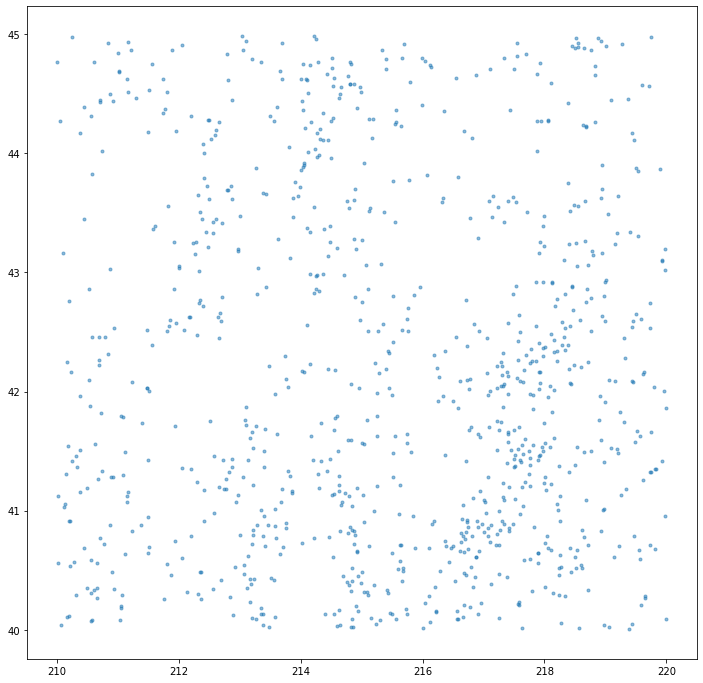

In [70]:
plt.figure(figsize = (12, 12))
plt.plot(timed_result_8[0].RA_central, timed_result_8[0].DEC_central, ".", alpha = 0.5)
plt.show()